In [1]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

ImportError: cannot import name unpack_labeled_data

In [2]:
fname = 'test_images/Frame0000Step%04d.tif'
frame_a  = openpiv.tools.imread( fname%163 )
frame_b  = openpiv.tools.imread( fname%168 )
fname2 = 'test_images/Frame0002Step%04d.tif'
frame_a2  = openpiv.tools.imread( fname2%163 )
frame_b2  = openpiv.tools.imread( fname2%168 )

/Users/timrudge/miniconda/envs/piv/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


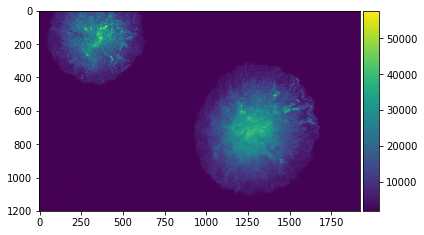

In [3]:
#io.imshow(frame_a)
io.imshow(frame_a2)

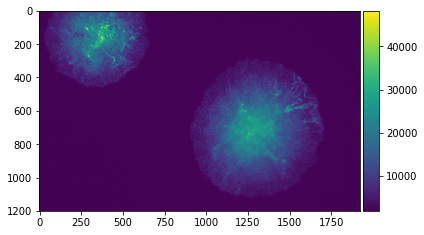

In [4]:
io.imshow(frame_b)

In [43]:
rcv_frame_a = frame_a.astype(np.float32)
cv_frame_a = 255.0*rcv_frame_a/rcv_frame_a.max()
rcv_frame_b = frame_b.astype(np.float32)
cv_frame_b = 255.0*rcv_frame_b/rcv_frame_b.max()

rcv_frame_a2 = frame_a2.astype(np.float32)
cv_frame_a2 = 255.0*rcv_frame_a2/rcv_frame_a2.max()
rcv_frame_b2 = frame_b2.astype(np.float32)
cv_frame_b2 = 255.0*rcv_frame_b2/rcv_frame_b2.max()
'''
# Translated by 20 pixels
cv_frame = cv_frame_a
cv_frame_a = cv_frame[20:,:]
cv_frame_b = cv_frame[:-20,:]

# Scale by 1.05
w,h = cv_frame_a.shape
sw,sh = w-118,h-192
scx,scy = w/sw,h/sh
cv_frame_b = cv2.resize(cv_frame_a[0:-118,0:-192], (h,w))
'''

# Crop images
cv_frame_a = cv_frame_a[500:884,1100:1484]
rcv_frame_a = rcv_frame_a[500:884,1100:1484]

cv_frame_b = cv_frame_b[500:884,1100:1484]
rcv_frame_b = rcv_frame_b[500:884,1100:1484]

cv_frame_a2 = cv_frame_a2[500:884,1100:1484]
rcv_frame_a2 = rcv_frame_a2[500:884,1100:1484]

cv_frame_b2 = cv_frame_b2[500:884,1100:1484]
rcv_frame_b2 = rcv_frame_b2[500:884,1100:1484]

# Gaussian smoothing
cv_frame_a = cv2.GaussianBlur(cv_frame_a,(5,5),0)
rcv_frame_a = cv2.GaussianBlur(rcv_frame_a,(5,5),0)
cv_frame_b = cv2.GaussianBlur(cv_frame_b,(5,5),0)
rcv_frame_b = cv2.GaussianBlur(rcv_frame_b,(5,5),0)
cv_frame_a2 = cv2.GaussianBlur(cv_frame_a2,(5,5),0)
rcv_frame_a2 = cv2.GaussianBlur(rcv_frame_a2,(5,5),0)
cv_frame_b2 = cv2.GaussianBlur(cv_frame_b2,(5,5),0)
rcv_frame_b2 = cv2.GaussianBlur(rcv_frame_b2,(5,5),0)

w,h = cv_frame_a.shape

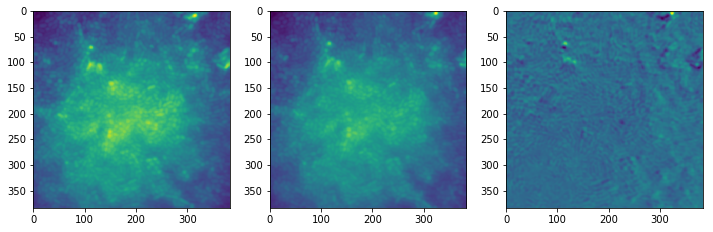

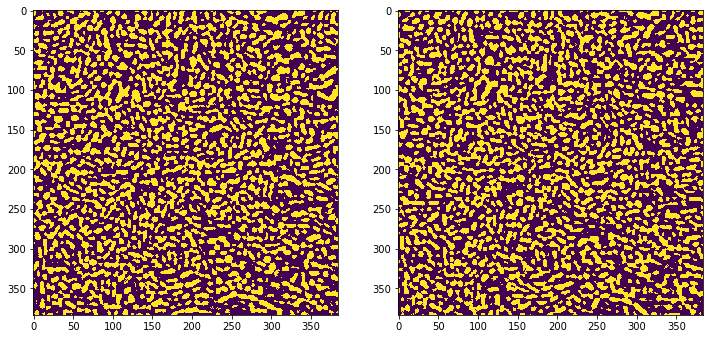

In [44]:
th_frame_a = cv2.adaptiveThreshold(cv_frame_a.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
th_frame_a2 = cv2.adaptiveThreshold(cv_frame_a2.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(cv_frame_a2)
th_frame_b = cv2.adaptiveThreshold(cv_frame_b.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
th_frame_b2 = cv2.adaptiveThreshold(cv_frame_b2.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,0)
plt.subplot(132)
plt.imshow(cv_frame_b2)
plt.subplot(133)
plt.imshow(cv_frame_b2-cv_frame_a2)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(th_frame_a2)
plt.subplot(122)
plt.imshow(th_frame_b2)

In [45]:
u, v, sig2noise = openpiv.process.extended_search_area_piv( th_frame_a.astype(np.int32), \
                                                           th_frame_b.astype(np.int32), \
                                                           window_size=64, \
                                                           overlap=48, \
                                                           dt=1, \
                                                           search_area_size=128, \
                                                           sig2noise_method='peak2peak' )

In [46]:
x, y = openpiv.process.get_coordinates( image_size=cv_frame_a.shape, window_size=64, overlap=48 )
#x, y = openpiv.process.get_coordinates( image_size=(500,500), window_size=50, overlap=40 )

In [47]:
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.0 )

In [48]:
u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)

In [49]:
x, y, u, v = openpiv.scaling.uniform(x, y, u, v, scaling_factor = 1 )

In [50]:
openpiv.tools.save(x, y, u, v, mask, 'exp1_001.txt' )

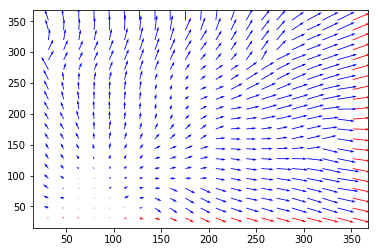

In [51]:
openpiv.tools.display_vector_field('exp1_001.txt', scale=200, width=0.0025)

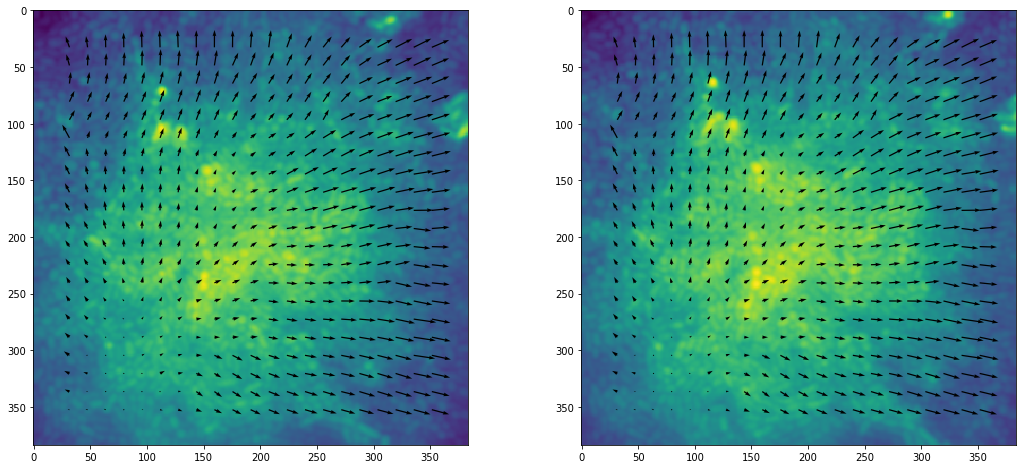

In [52]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(cv_frame_a)
plt.quiver( x, cv_frame_a.shape[0]-y, u, v )

plt.subplot(122)
plt.imshow(cv_frame_b)
plt.quiver( x, cv_frame_b.shape[0]-y, u, v )

(384, 384)

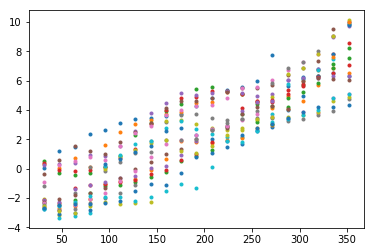

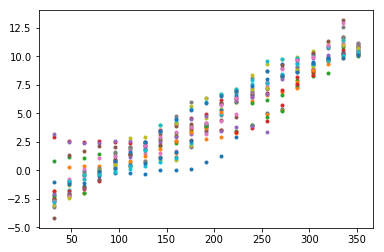

In [53]:
#plt.hist(v.ravel())
plt.figure()
plt.plot(y, v, '.')
#plt.plot((1.0/0.9-1)*(y.ravel()-200), y.ravel(), '.')

plt.figure()
plt.plot(x.transpose(), u.transpose(), '.')
#plt.plot((1.0/0.9-1)*(x.ravel()+249), x.ravel(), '.')
#plt.xlim((30,50))
cv_frame_b.shape

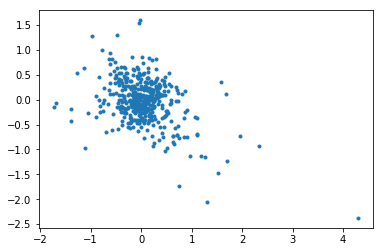

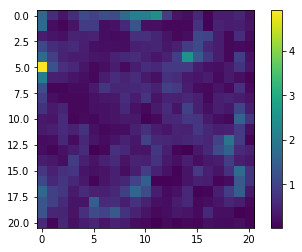

In [74]:
su = cv2.GaussianBlur(u,(5,5),0)
sv = cv2.GaussianBlur(v,(5,5),0)

xerr = (su.ravel()-u.ravel())
yerr = (sv.ravel()-v.ravel())

#plt.plot(su.ravel(), x.ravel(), '.')
#plt.plot(x.ravel()*0.05, u.ravel(),'.')
xtrue = (1.0/0.9-1)*(x.ravel()+250)
ytrue = (1.0/0.9-1)*(y.ravel()-200)


#plt.plot(xtrue, u.ravel(), '.')
#plt.plot(ytrue, v.ravel(), '.')

plt.figure()
plt.plot(xerr,yerr,'.')
#plt.hist(np.log(np.sqrt(xerr*xerr + yerr*yerr)), 50)
#plt.yscale('log', nonposy='clip')
xerr.mean()

plt.figure()
xerr.shape=su.shape
yerr.shape=sv.shape
sqerr = np.sqrt(yerr*yerr+xerr*xerr)
plt.imshow(sqerr)
plt.colorbar()

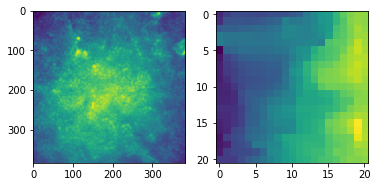

In [55]:
plt.subplot(121)
plt.imshow(cv_frame_a)
plt.subplot(122)
plt.imshow(u)

-0.089259846874875315

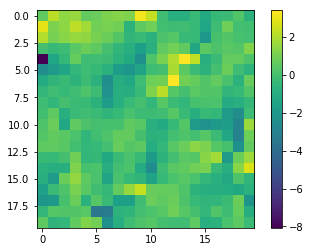

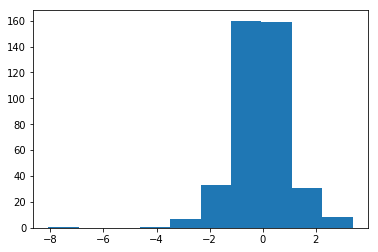

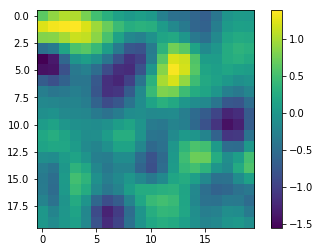

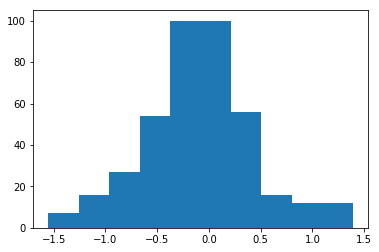

In [106]:
plt.figure()
du = np.diff(u, axis=0)
dv = np.diff(v, axis=1)
div = du[:,:-1] + dv[:-1,:]
plt.imshow(div)
plt.colorbar()
plt.figure()
plt.hist(div.ravel())
np.mean(div.ravel())

plt.figure()
dsu = np.diff(su, axis=0)
dsv = np.diff(sv, axis=1)
sdiv = dsu[:,:-1] + dsv[:-1,:]
plt.imshow(sdiv)
plt.colorbar()
plt.figure()
plt.hist(sdiv.ravel())
np.mean(sdiv.ravel())

(21, 21)

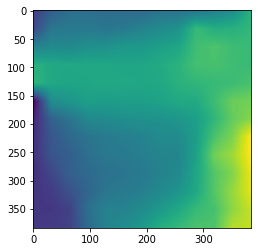

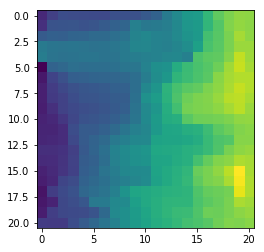

In [57]:
(cx,cy) = cv2.convertMaps(x.astype(np.float32), y.astype(np.float32), cv2.CV_32FC1)
hhx = (x-u).astype(np.float32)
hhy = (y-v).astype(np.float32)
xx = np.linspace(0,12,w).astype(np.float32)
yy = np.linspace(0,12,h).astype(np.float32)
xv,yv = np.meshgrid(xx,yy)
ufull = cv2.remap(u, xv.astype(np.float32), yv.astype(np.float32), cv2.INTER_LINEAR).astype(np.float32)
vfull = cv2.remap(v, xv.astype(np.float32), yv.astype(np.float32), cv2.INTER_LINEAR).astype(np.float32)
plt.imshow(ufull)
plt.figure()
plt.imshow(u)
u.shape

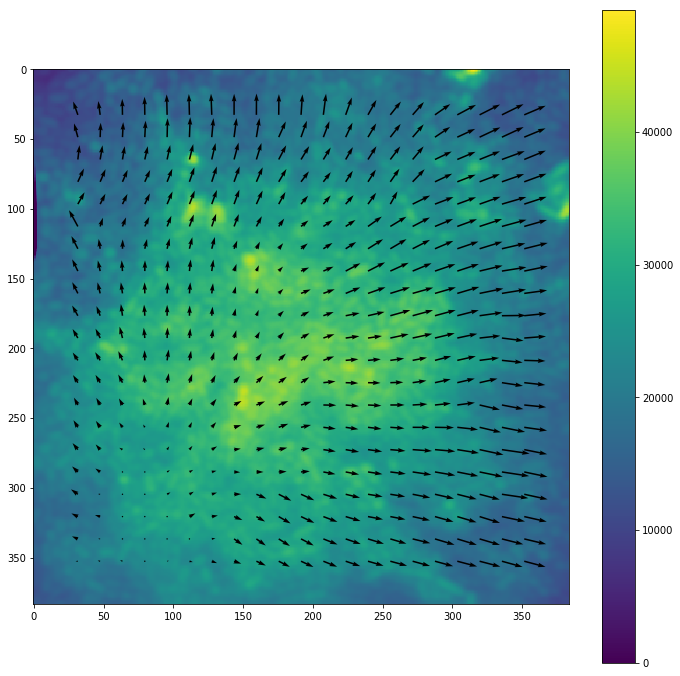

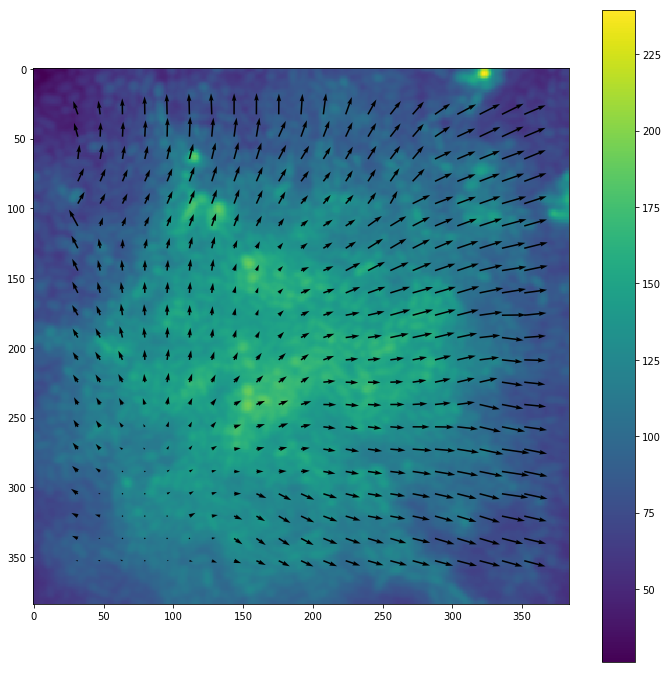

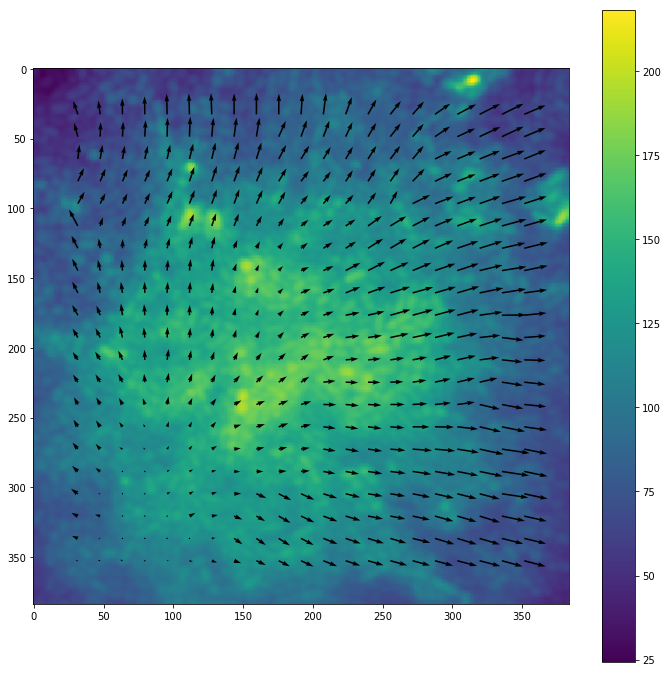

In [62]:

xv,yv = np.meshgrid(np.arange(0,w),np.arange(0,h))
w_frame_a = cv2.remap(rcv_frame_a, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
w_frame_b = cv2.remap(rcv_frame_b, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
w_frame_a2 = cv2.remap(rcv_frame_a2, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
w_frame_b2 = cv2.remap(rcv_frame_b2, xv.astype(np.float32)-ufull, yv.astype(np.float32)+vfull[:,-1:], cv2.INTER_LINEAR)
plt.figure(figsize=(12,12))
plt.imshow(w_frame_a2)
plt.colorbar()
plt.quiver( x, cv_frame_b2.shape[0]-y, u, v )
plt.figure(figsize=(12,12))
plt.imshow(cv_frame_b2)
plt.colorbar()
plt.quiver( x, cv_frame_b2.shape[0]-y, u, v )
plt.figure(figsize=(12,12))
plt.imshow(cv_frame_a2)
plt.colorbar()
plt.quiver( x, cv_frame_a2.shape[0]-y, u, v )

"\nsdf = cv2.GaussianBlur(df, (5,5), 0)\nplt.figure()\nplt.imshow(sdf)\nplt.colorbar()\nsdiv = cv2.GaussianBlur(div, (5,5), 0)\nplt.figure()\nplt.plot(sdf[0:-1,0:-1].ravel(), sdiv.ravel(), '.')\n#plt.ylim(0,0.5)\n"

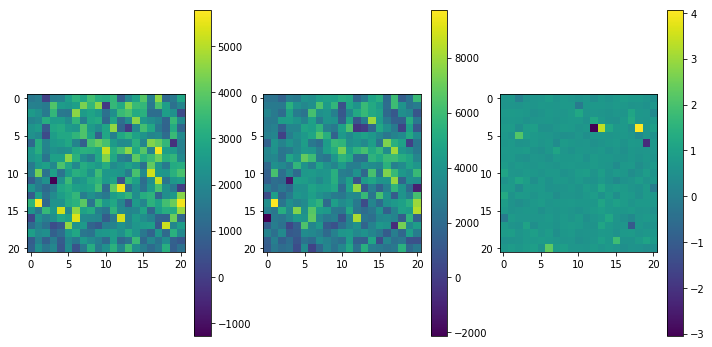

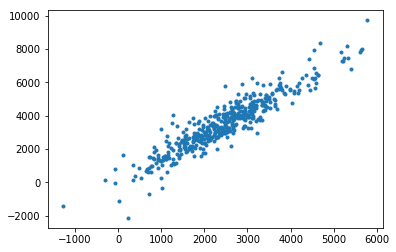

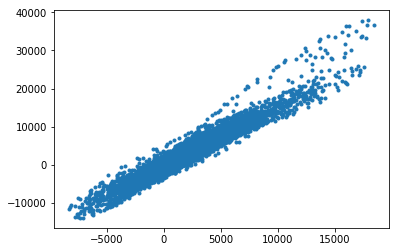

In [64]:
df_full = rcv_frame_b - w_frame_a
df_full2 = rcv_frame_b2 - w_frame_a2
df = cv2.remap(df_full, x.astype(np.float32),  y.astype(np.float32), cv2.INTER_LINEAR)
df2 = cv2.remap(df_full2, x.astype(np.float32),  y.astype(np.float32), cv2.INTER_LINEAR)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(df)
plt.colorbar()
plt.subplot(132)
plt.imshow(df2)
plt.colorbar()
plt.subplot(133)
plt.imshow(df/df2)
plt.colorbar()
df.shape

plt.figure()
plt.plot(df.ravel(), df2.ravel(), '.')

plt.figure()
dftot = rcv_frame_b - rcv_frame_a
dftot2 = rcv_frame_b2 - rcv_frame_a2
plt.plot(dftot.ravel(), dftot2.ravel(), '.')
'''
sdf = cv2.GaussianBlur(df, (5,5), 0)
plt.figure()
plt.imshow(sdf)
plt.colorbar()
sdiv = cv2.GaussianBlur(div, (5,5), 0)
plt.figure()
plt.plot(sdf[0:-1,0:-1].ravel(), sdiv.ravel(), '.')
#plt.ylim(0,0.5)
'''

(array([  1.20000000e+02,   7.22000000e+02,   2.12470000e+04,
          1.16444000e+05,   8.43500000e+03,   3.30000000e+02,
          9.60000000e+01,   2.90000000e+01,   1.80000000e+01,
          1.50000000e+01]),
 array([-13986.75   ,  -8795.00625,  -3603.2625 ,   1588.48125,
          6780.225  ,  11971.96875,  17163.7125 ,  22355.45625,
         27547.2    ,  32738.94375,  37930.6875 ]),
 <a list of 10 Patch objects>)

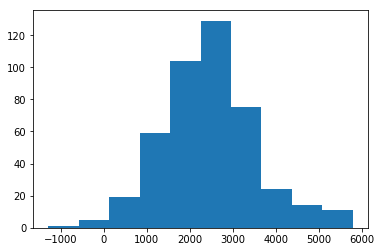

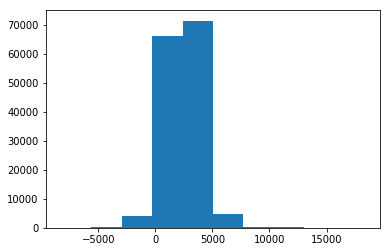

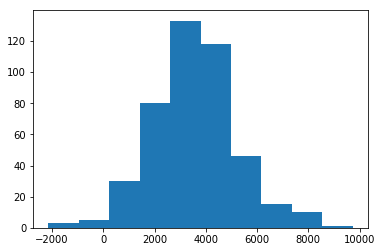

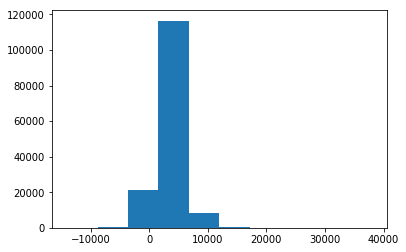

In [73]:
plt.figure()
plt.hist(df.ravel())
plt.figure()
plt.hist(dftot.ravel())
plt.figure()
plt.hist(df2.ravel())
plt.figure()
plt.hist(dftot2.ravel())

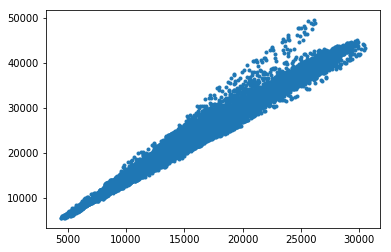

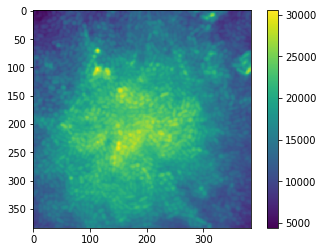

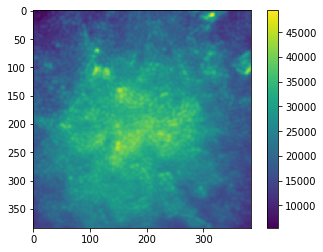

In [80]:
plt.figure()
plt.plot(rcv_frame_a.ravel(), rcv_frame_a2.ravel(), '.')
plt.figure()
plt.imshow(rcv_frame_a)
plt.colorbar()
plt.figure()
plt.imshow(rcv_frame_a2)
plt.colorbar()

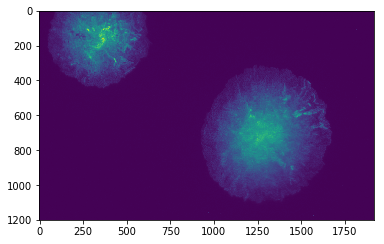

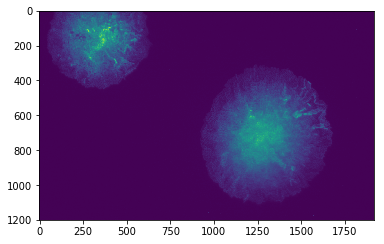

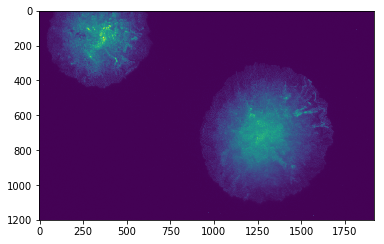

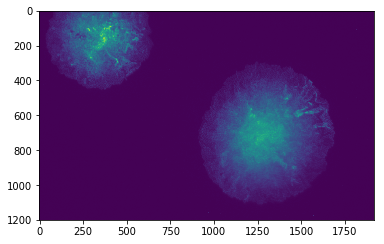

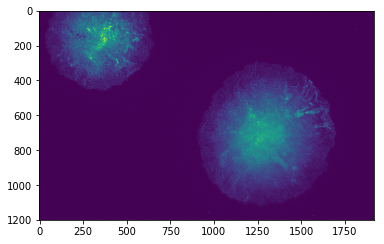

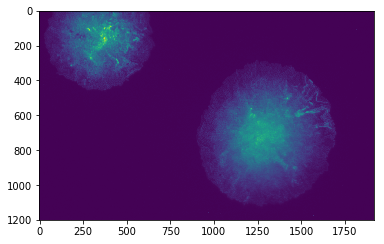

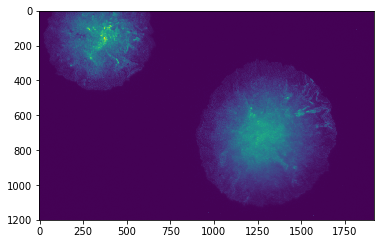

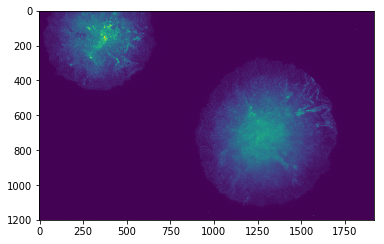

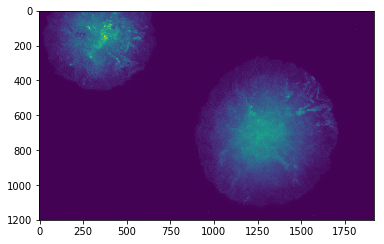

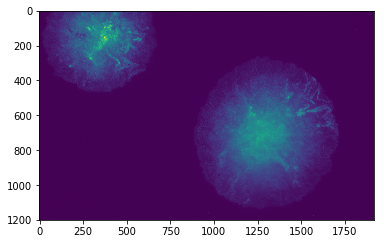

In [94]:
fname1 = 'test_images/Frame0000Step%04d.tif'
fname2 = 'test_images/Frame0002Step%04d.tif'
frames1 = np.zeros((1200,1920,10))
frames2 = np.zeros((1200,1920,10))
for i in range(10):
    frames1[:,:,i]  = openpiv.tools.imread( fname1%(i+163) )
    frames2[:,:,i]  = openpiv.tools.imread( fname2%(i+163) )
    plt.figure()
    plt.imshow(frames[:,:,i])

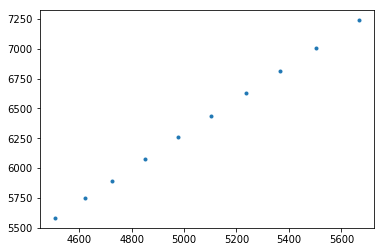

In [97]:
diffs1 = np.mean(frames1,axis=(0,1))
diffs2 = np.mean(frames2,axis=(0,1))
plt.figure()
plt.plot(diffs1.ravel(), diffs2.ravel(), '.')

(21, 21)
(20, 20)


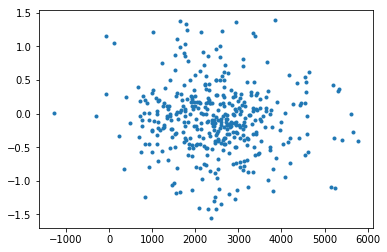

In [107]:
plt.figure()
print df.shape
print div.shape
plt.plot(df[:-1,:-1].ravel(), sdiv.ravel(), '.')